Primero importamos las librerías que necesitaremos a lo largo de la tarea, además de fijar una semilla para que los resultados sean reproducibles

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_rcv1
from scipy.sparse import csr_matrix

np.random.seed(33)

Ahora creamos una función para poder cargar los datos. Notemos que filtramos los datos solo en las etiquetas relevante y filtramos los datos para que solo tengan una de esas etiquetas

In [3]:
def cargar_datos():

    rcv1 = fetch_rcv1()

    categories = ["ECAT", "CCAT", "MCAT", "GCAT"]
    indices = [rcv1.target_names.tolist().index(cat) for cat in categories]

    y = rcv1.target[:, indices].toarray()
    filter = np.sum(y, axis=1) == 1

    X = rcv1.data[filter]
    y = y[filter]

    mapa = {"ECAT": 0, "CCAT": 1, "MCAT": 2, "GCAT": 3}
    y = [mapa[categories[np.argmax(row)]] for row in y]
    y = np.array(y)

    X, Xtest, y, ytest = train_test_split(X, y, test_size = 23149, shuffle = False)
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 20000, shuffle = True, random_state = 33)

    return Xtrain, ytrain, Xval, yval, Xtest, ytest


Además creamos una función para poder escoger un subconjunto de los datos para poder implementar correctamente el acceso a un batch

In [4]:
def random_subset(tamano, X, Y):
    n, d = X.shape
    indices = np.random.choice(n, size = tamano, replace = False)
    newX = X[indices]
    newY = Y[indices]
    return newX, newY

Ahora implementamos el algoritmo de Langevin para optimizar la función objetivo de una red neuronal. Usamos la implementación de la tarea anterior y la modificamos acordemente según o mostrado de este algoritmo en la tarea. El único cambio relevante que hice fue que me quedé con los parametros finales y no promedié todos los encontrados (ya que para los modelos grandes no me iba a caber guardarlo todo en memoria). Se puede revisar la implementación a continuación, pero no tiene ningún detalle especial

In [5]:
def NeuralNetworkAdaptative(X, Y, eta, m, p, Lambda):

    tiempo_inicial = time.time()
    iters = 0
    d = X.shape[1]
    K = len(np.unique(Y))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)

    R1 = np.zeros((d, p))
    r1 = np.zeros(p)
    R2 = np.zeros((p, K))
    r2 = np.zeros(K)

    while time.time() - tiempo_inicial < 60.0:

        Xbatch, Ybatch = random_subset(m, X, Y)

        z1 = Xbatch.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        z2 = a1.dot(W2) + b2
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        data_loss = np.sum(corect_logprobs)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        b2grad = np.sum(dscores, axis=0)

        dhidden = dscores.dot(W2.T)
        dhidden[z1 <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        b1grad = np.sum(dhidden, axis=0)

        R1 += W1grad * W1grad
        r1 += b1grad * b1grad
        R2 += W2grad * W2grad
        r2 += b2grad * b2grad

        W1 -= ((eta / np.sqrt(R1 + 1e-8)) * W1grad)
        b1 -= ((eta / np.sqrt(r1 + 1e-8)) * b1grad)
        W2 -= ((eta / np.sqrt(R2 + 1e-8)) * W2grad)
        b2 -= ((eta / np.sqrt(r2 + 1e-8)) * b2grad)

        iters += 1

        if np.linalg.norm(W1grad) + np.linalg.norm(W2grad) < 1e-5:
            break

    return W1, b1, W2, b2, time.time() - tiempo_inicial, iters


Además implementamos el modelo de Langevin, se puede observar la implementación abajo la cual no tiene ningún detalle interesante con respecto a lo visto en clases y lo programado en la tarea anterior. Lo único importante a notar es que escogí $\beta = p + d$, ya que en caso contrario los pesos de las matrices crecerían mucho y rápidamente el modelo haría overflow, escogí esos valores ya que son los clásicos para la inicialización de los parámetros, y por lo tanto no debería irse al infinito.

In [38]:
def NeuralNetworkLangevin(X, Y, eta, m, p, Lambda):

    tiempo_inicial = time.time()
    iters = 0
    d = X.shape[1]
    K = len(np.unique(Y))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)

    while time.time() - tiempo_inicial < 60.0:

        Xbatch, Ybatch = random_subset(m, X, Y)

        z1 = Xbatch.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        z2 = a1.dot(W2) + b2
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        data_loss = np.sum(corect_logprobs)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        b2grad = np.sum(dscores, axis=0)

        dhidden = dscores.dot(W2.T)
        dhidden[z1 <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        b1grad = np.sum(dhidden, axis=0)

        W1 -= (eta * W1grad + np.random.randn(d, p) * np.sqrt(eta/(d+p)))
        b1 -= (eta * b1grad + np.random.randn(p) * np.sqrt(eta/(d+p)))
        W2 -= (eta * W2grad + np.random.randn(p, K) * np.sqrt(eta/(d+p)))
        b2 -= (eta * b2grad + np.random.randn(K) * np.sqrt(eta/(d+p)))

        iters += 1

        if np.linalg.norm(W1grad) + np.linalg.norm(W2grad) < 1e-5:
            break

    return W1, b1, W2, b2, time.time() - tiempo_inicial, iters


Además creamos una función que vea la proporción de error que tiene el modelo en unos datos dados.

In [40]:
def validar(W1, b1, W2, b2, X, Y):
    z1 = X.dot(W1) + b1
    a1 = np.maximum(z1, 0)
    z2 = a1.dot(W2) + b2
    a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
    Ypred = np.argmax(a2, axis=1)
    error = np.mean(Ypred != Y)
    return error

Comencemos con el experimento, lo primero es cargar los datos

In [8]:
Xtrain, ytrain, Xval, yval, Xtest, ytest = cargar_datos()

Ahora corremos los modelos para encontrar los mejores parametros para el algoritmo adaptativo. Recordemos que le damos un minuto a cada uno

In [9]:
for eta in [0.01, 0.001, 0.0001]:
    for m in [100, 1000, 10000]:
        for p in [100, 1000, 10000]:
            for Lambda in [0, 0.01, 0.1]:
                W1, b1, W2, b2, tiempo, iters = NeuralNetworkAdaptative(Xtrain, ytrain, eta, m, p, Lambda)
                error = validar(W1, b1, W2, b2, Xval, yval)
                print(f"El modelo con parámetros ({eta:6.4f}, {m:<5}, {p:<5}, {Lambda:4.2f}) se tardó {tiempo:5.2f}s en {iters:<4} iteraciones y tuvo error de {error:.5f}")

El modelo con parámetros (0.0100, 100  , 100  , 0.00) se tardó 60.07s en 277  iteraciones y tuvo error de 0.03925
El modelo con parámetros (0.0100, 100  , 100  , 0.01) se tardó 60.10s en 263  iteraciones y tuvo error de 0.12970
El modelo con parámetros (0.0100, 100  , 100  , 0.10) se tardó 60.10s en 274  iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 1000 , 0.00) se tardó 60.98s en 39   iteraciones y tuvo error de 0.05335
El modelo con parámetros (0.0100, 100  , 1000 , 0.01) se tardó 61.24s en 39   iteraciones y tuvo error de 0.14335
El modelo con parámetros (0.0100, 100  , 1000 , 0.10) se tardó 61.05s en 39   iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 10000, 0.00) se tardó 72.82s en 4    iteraciones y tuvo error de 0.29530
El modelo con parámetros (0.0100, 100  , 10000, 0.01) se tardó 73.02s en 4    iteraciones y tuvo error de 0.51770
El modelo con parámetros (0.0100, 100  , 10000, 0.10) se tardó 72.94s en 4    iteracione

Podemos ver que hay modelos mejores y peores, pero el que tuvo los mejores rendimientos fue el de parámetros $(\eta = 0.01, m = 10000, p = 100, \lambda = 0)$ con un error del 3.28% así que nos quedaremos con dicho modelo. Ahora hagamos la búsqueda para el algoritmo de Langevin con paso fijo

In [41]:
for eta in [0.01, 0.001, 0.0001]:
    for m in [100, 1000, 10000]:
        for p in [100, 1000, 10000]:
            for Lambda in [0, 0.01, 0.1]:
                W1, b1, W2, b2, tiempo, iters = NeuralNetworkLangevin(Xtrain, ytrain, eta, m, p, Lambda)
                error = validar(W1, b1, W2, b2, Xval, yval)
                print(f"El modelo con parámetros ({eta:6.4f}, {m:<5}, {p:<5}, {Lambda:4.2f}) se tardó {tiempo:5.2f}s en {iters:<4} iteraciones y tuvo error de {error:.5f}")

El modelo con parámetros (0.0100, 100  , 100  , 0.00) se tardó 60.02s en 193  iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 100  , 0.01) se tardó 60.27s en 194  iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 100  , 0.10) se tardó 60.28s en 194  iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 1000 , 0.00) se tardó 62.38s en 25   iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 1000 , 0.01) se tardó 62.36s en 25   iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 1000 , 0.10) se tardó 62.35s en 25   iteraciones y tuvo error de 0.56195
El modelo con parámetros (0.0100, 100  , 10000, 0.00) se tardó 82.97s en 3    iteraciones y tuvo error de 0.58800
El modelo con parámetros (0.0100, 100  , 10000, 0.01) se tardó 82.86s en 3    iteraciones y tuvo error de 0.56495
El modelo con parámetros (0.0100, 100  , 10000, 0.10) se tardó 82.80s en 3    iteracione

Lo primero es notar que los modelos tuvieron un rendimiento bastante malo. Esto se debe a que (en otros experimentos que hice se pudo concluir) el modelo converge lentamente, por lo que en un minuto (no puedo darle más tiempo porque ya hay que correr 81 modelos, de hecho pagué para usar la máquina más cara del colab) lo único que alcanza a aprender es asignarle a todos los datos la etiqueta $1$, ya que hay un 56.19% de los datos con dicha etiqueta. Por lo tanto, nos quedaremos con el modelo con parámetros $(\eta = 0.01, m = 100, p = 100, \lambda = 0)$, ya que alcanzó el error antes mencionado, y tiene los parámetros óptimos para "aprender más rápido" que es lo que hace falta. Ahora implementemos modelos para poder capturar como evoluciona la función de pérdida a lo largo de la ejecución del modelo para los parámetros escogidos. Primero para el algoritmo adaptativo 

In [73]:
def NeuralNetworkAdaptativeLoss(Xtrain, Ytrain, Xtest, Ytest, eta, m, p, Lambda, iters):

    d = Xtrain.shape[1]
    K = len(np.unique(Ytrain))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)

    R1 = np.zeros((d, p))
    r1 = np.zeros(p)
    R2 = np.zeros((p, K))
    r2 = np.zeros(K)

    Losstrain = []
    Losstest = []

    for iter in range(iters):

        Xbatch, Ybatch = random_subset(m, Xtrain, Ytrain)
        Xbatcht, Ybatcht = random_subset(m, Xtest, Ytest)

        z1 = Xbatch.dot(W1) + b1
        z1t = Xbatcht.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        a1t = np.maximum(z1t, 0)
        z2 = a1.dot(W2) + b2
        z2t = a1t.dot(W2) + b2
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
        a2t = np.exp(z2t) / np.sum(np.exp(z2t), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        corect_logprobst = -np.log(a2t[range(m), Ybatcht])
        data_loss = np.sum(corect_logprobs)/m
        data_losst = np.sum(corect_logprobst)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss
        losst = data_losst + reg_loss

        Losstrain.append(loss)
        Losstest.append(losst)

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        b2grad = np.sum(dscores, axis=0)

        dhidden = dscores.dot(W2.T)
        dhidden[z1 <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        b1grad = np.sum(dhidden, axis=0)

        R1 += W1grad * W1grad
        r1 += b1grad * b1grad
        R2 += W2grad * W2grad
        r2 += b2grad * b2grad

        W1 -= ((eta / np.sqrt(R1 + 1e-8)) * W1grad)
        b1 -= ((eta / np.sqrt(r1 + 1e-8)) * b1grad)
        W2 -= ((eta / np.sqrt(R2 + 1e-8)) * W2grad)
        b2 -= ((eta / np.sqrt(r2 + 1e-8)) * b2grad)


    return Losstrain, Losstest

Y ahora para el algoritmo de Langevin con paso fijo

In [72]:
def NeuralNetworkLangevinLoss(Xtrain, Ytrain, Xtest, Ytest, eta, m, p, Lambda, iters):

    d = Xtrain.shape[1]
    K = len(np.unique(Ytrain))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    b1 = np.zeros(p)
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    b2 = np.zeros(K)

    Losstrain = []
    Losstest = []

    for iter in range(iters):

        Xbatch, Ybatch = random_subset(m, Xtrain, Ytrain)
        Xbatcht, Ybatcht = random_subset(m, Xtest, Ytest)

        z1 = Xbatch.dot(W1) + b1
        z1t = Xbatcht.dot(W1) + b1
        a1 = np.maximum(z1, 0)
        a1t = np.maximum(z1t, 0)
        z2 = a1.dot(W2) + b2
        z2t = a1t.dot(W2) + b2
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
        a2t = np.exp(z2t) / np.sum(np.exp(z2t), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        corect_logprobst = -np.log(a2t[range(m), Ybatcht])
        data_loss = np.sum(corect_logprobs)/m
        data_losst = np.sum(corect_logprobst)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        loss = data_loss + reg_loss
        losst = data_losst + reg_loss

        Losstrain.append(loss)
        Losstest.append(losst)

        dscores = a2
        dscores[range(m), Ybatch] -= 1
        dscores /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        b2grad = np.sum(dscores, axis=0)

        dhidden = dscores.dot(W2.T)
        dhidden[z1 <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        b1grad = np.sum(dhidden, axis=0)

        W1 -= (eta * W1grad + np.random.randn(d, p) * np.sqrt(eta/(d+p)))
        b1 -= (eta * b1grad + np.random.randn(p) * np.sqrt(eta/(d+p)))
        W2 -= (eta * W2grad + np.random.randn(p, K) * np.sqrt(eta/(d+p)))
        b2 -= (eta * b2grad + np.random.randn(K) * np.sqrt(eta/(d+p)))


    return Losstrain, Losstest


Con dichas funciones obtenemos los datos requeridos

In [47]:
LosstrainAdaptative, LosstestAdaptative = NeuralNetworkAdaptativeLoss(Xtrain, ytrain, Xtest, ytest, 0.01, 10000, 100, 0, 150)
LosstrainLangevin, LosstestLangevin = NeuralNetworkLangevinLoss(Xtrain, ytrain, Xtest, ytest, 0.01, 100, 100, 0, 193)

Graficamos para el algoritmo adaptativo

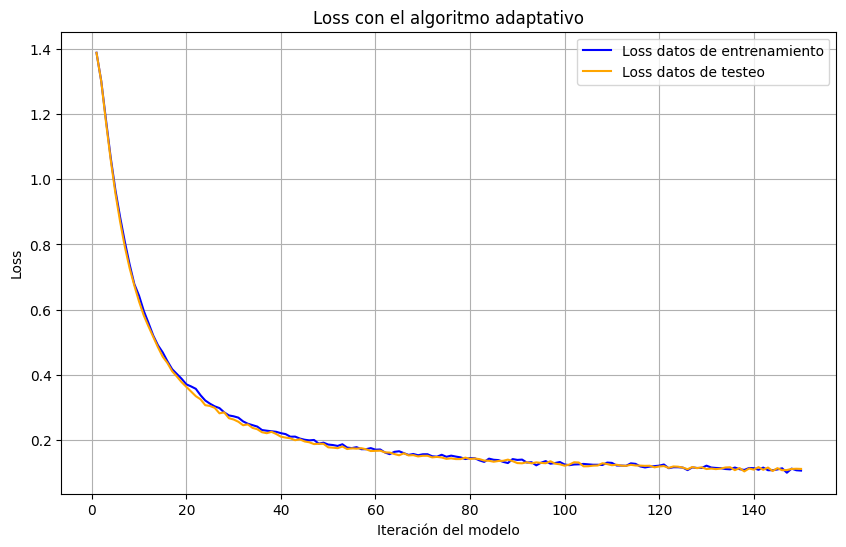

In [48]:
x = np.linspace(1, len(LosstrainAdaptative), len(LosstrainAdaptative))

plt.figure(figsize=(10, 6))

plt.plot(x, LosstrainAdaptative, label = 'Loss datos de entrenamiento', color = 'blue')
plt.plot(x, LosstestAdaptative, label = 'Loss datos de testeo', color = 'orange')

plt.title('Loss con el algoritmo adaptativo')
plt.xlabel('Iteración del modelo')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Podemos ver que la función de pérdida disminuye a un buen ritmo y no hay un sobreajuste. Ahora grafiquemos para el algoritmo de Langevin con paso fijo.

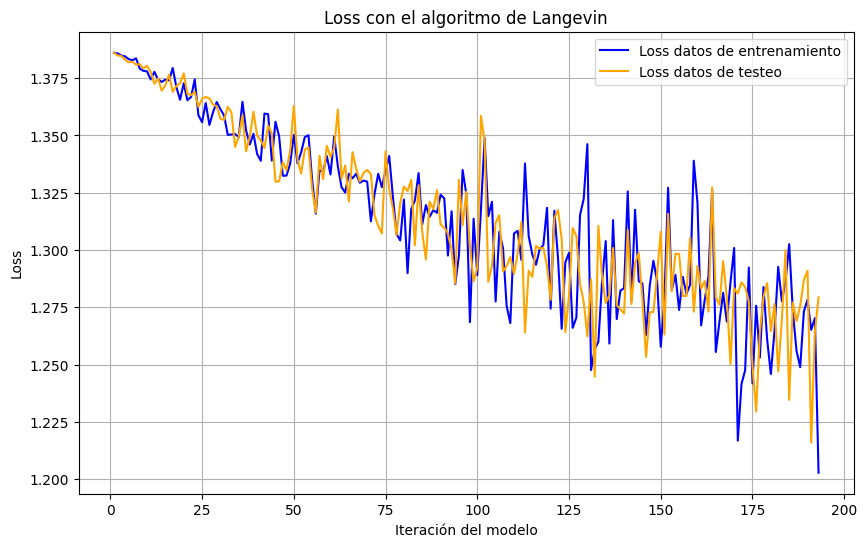

In [49]:
x = np.linspace(1, len(LosstrainLangevin), len(LosstrainLangevin))

plt.figure(figsize=(10, 6))

plt.plot(x, LosstrainLangevin, label = 'Loss datos de entrenamiento', color = 'blue')
plt.plot(x, LosstestLangevin, label = 'Loss datos de testeo', color = 'orange')

plt.title('Loss con el algoritmo de Langevin')
plt.xlabel('Iteración del modelo')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Se puede ver que va disminuyendo a paso lento (en el mismo tiempo disminuyó mucho menos que el modelo adaptativo), y que su comportamiento es muy errático, lo cual tiene sentido ya que usar azar en el modelo nos permite movernos más en el espacio. Ahora estudiemos la estabilidad de los algoritmos, para esto implementemos una función que realice lo pedido en el enunciado, primero para el algoritmo adaptativo

In [75]:
def NeuralNetworkAdaptativeStable(X, Y, eta, m, p, Lambda, iters):

    d = X.shape[1]
    K = len(np.unique(Y))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    W1m = W1.copy()
    b1 = np.zeros(p)
    b1m = b1.copy()
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    W2m = W2.copy()
    b2 = np.zeros(K)
    b2m = b2.copy()

    R1 = np.zeros((d, p))
    R1m = np.zeros((d, p))
    r1 = np.zeros(p)
    r1m = np.zeros(p)
    R2 = np.zeros((p, K))
    R2m = np.zeros((p, K))
    r2 = np.zeros(K)
    r2m = np.zeros(K)

    diff = []
    cambio = []

    for iter in range(iters):

        indices = np.random.choice(X.shape[0], size = m, replace = False)
        Xbatch = X[indices]
        Ybatch = Y[indices]

        Xbatchm = Xbatch.copy()
        Ybatchm = Ybatch.copy()

        if 0 in indices:
            pos = np.where(indices == 0)[0][0]
            Xbatchm[pos] = np.zeros_like(Xbatch[pos])
            Ybatchm[pos] = 0
            cambio.append(True)
        else:
            cambio.append(False)

        z1 = Xbatch.dot(W1) + b1
        z1m = Xbatchm.dot(W1m) + b1m
        a1 = np.maximum(z1, 0)
        a1m = np.maximum(z1m, 0)
        z2 = a1.dot(W2) + b2
        z2m = a1m.dot(W2m) + b2m
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
        a2m = np.exp(z2m) / np.sum(np.exp(z2m), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        corect_logprobsm = -np.log(a2m[range(m), Ybatchm])
        data_loss = np.sum(corect_logprobs)/m
        data_lossm = np.sum(corect_logprobsm)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        reg_lossm = 0.5 * Lambda * (np.sum(W1m * W1m) + np.sum(W2m * W2m))
        loss = data_loss + reg_loss
        lossm = data_lossm + reg_loss

        diff.append(np.sqrt(np.sum((W1 - W1m)*(W1 - W1m)) + np.sum((W2 - W2m)*(W2 - W2m)) + np.sum((b1 - b1m)*(b1 - b1m)) + np.sum((b2 - b2m)*(b2 - b2m))))

        dscores = a2
        dscoresm = a2m
        dscores[range(m), Ybatch] -= 1
        dscoresm[range(m), Ybatchm] -= 1
        dscores /= m
        dscoresm /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        W2gradm = a1m.T.dot(dscoresm) + Lambda * W2m
        b2grad = np.sum(dscores, axis=0)
        b2gradm = np.sum(dscoresm, axis=0)

        dhidden = dscores.dot(W2.T)
        dhiddenm = dscoresm.dot(W2m.T)
        dhidden[z1 <= 0] = 0
        dhiddenm[z1m <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        W1gradm = Xbatchm.T.dot(dhiddenm) + Lambda * W1m
        b1grad = np.sum(dhidden, axis=0)
        b1gradm = np.sum(dhiddenm, axis=0)

        R1 += W1grad * W1grad
        R1m += W1gradm * W1gradm
        r1 += b1grad * b1grad
        r1m += b1gradm * b1gradm
        R2 += W2grad * W2grad
        R2m += W2gradm * W2gradm
        r2 += b2grad * b2grad
        r2m += b2gradm * b2gradm

        W1 -= ((eta / np.sqrt(R1 + 1e-8)) * W1grad)
        W1m -= ((eta / np.sqrt(R1m + 1e-8)) * W1gradm)
        b1 -= ((eta / np.sqrt(r1 + 1e-8)) * b1grad)
        b1m -= ((eta / np.sqrt(r1m + 1e-8)) * b1gradm)
        W2 -= ((eta / np.sqrt(R2 + 1e-8)) * W2grad)
        W2m -= ((eta / np.sqrt(R2m + 1e-8)) * W2gradm)
        b2 -= ((eta / np.sqrt(r2 + 1e-8)) * b2grad)
        b2m -= ((eta / np.sqrt(r2m + 1e-8)) * b2gradm)


    return diff, cambio

Y ahora para el algoritmo de Langevin con paso fijo

In [68]:
def NeuralNetworkLangevinStable(X, Y, eta, m, p, Lambda, iters):

    d = X.shape[1]
    K = len(np.unique(Y))

    W1 = np.random.randn(d, p)*np.sqrt(2.0/d)
    W1m = W1.copy()
    b1 = np.zeros(p)
    b1m = b1.copy()
    W2 = np.random.randn(p, K)*np.sqrt(2.0/p)
    W2m = W2.copy()
    b2 = np.zeros(K)
    b2m = b2.copy()

    diff = []
    cambio = []

    for iter in range(iters):

        indices = np.random.choice(X.shape[0], size = m, replace = False)
        Xbatch = X[indices]
        Ybatch = Y[indices]

        Xbatchm = Xbatch.copy()
        Ybatchm = Ybatch.copy()

        if 0 in indices:
            pos = np.where(indices == 0)[0][0]
            Xbatchm[pos] = np.zeros_like(Xbatch[pos])
            Ybatchm[pos] = 0
            cambio.append(True)
        else:
            cambio.append(False)

        z1 = Xbatch.dot(W1) + b1
        z1m = Xbatchm.dot(W1m) + b1m
        a1 = np.maximum(z1, 0)
        a1m = np.maximum(z1m, 0)
        z2 = a1.dot(W2) + b2
        z2m = a1m.dot(W2m) + b2m
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis = 1, keepdims = True)
        a2m = np.exp(z2m) / np.sum(np.exp(z2m), axis = 1, keepdims = True)

        corect_logprobs = -np.log(a2[range(m), Ybatch])
        corect_logprobsm = -np.log(a2m[range(m), Ybatchm])
        data_loss = np.sum(corect_logprobs)/m
        data_lossm = np.sum(corect_logprobsm)/m

        reg_loss = 0.5 * Lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
        reg_lossm = 0.5 * Lambda * (np.sum(W1m * W1m) + np.sum(W2m * W2m))
        loss = data_loss + reg_loss
        lossm = data_lossm + reg_loss

        diff.append(np.sqrt(np.sum((W1 - W1m)*(W1 - W1m)) + np.sum((W2 - W2m)*(W2 - W2m)) + np.sum((b1 - b1m)*(b1 - b1m)) + np.sum((b2 - b2m)*(b2 - b2m))))

        dscores = a2
        dscoresm = a2m
        dscores[range(m), Ybatch] -= 1
        dscoresm[range(m), Ybatchm] -= 1
        dscores /= m
        dscoresm /= m

        W2grad = a1.T.dot(dscores) + Lambda * W2
        W2gradm = a1m.T.dot(dscoresm) + Lambda * W2m
        b2grad = np.sum(dscores, axis=0)
        b2gradm = np.sum(dscoresm, axis=0)

        dhidden = dscores.dot(W2.T)
        dhiddenm = dscoresm.dot(W2m.T)
        dhidden[z1 <= 0] = 0
        dhiddenm[z1m <= 0] = 0

        W1grad = Xbatch.T.dot(dhidden) + Lambda * W1
        W1gradm = Xbatchm.T.dot(dhiddenm) + Lambda * W1m
        b1grad = np.sum(dhidden, axis=0)
        b1gradm = np.sum(dhiddenm, axis=0)

        random1 = np.random.randn(d, p) * np.sqrt(eta/(d+p))
        random2 = np.random.randn(p) * np.sqrt(eta/(d+p))
        random3 = np.random.randn(p, K) * np.sqrt(eta/(d+p))
        random4 = np.random.randn(K) * np.sqrt(eta/(d+p))

        W1 -= (eta * W1grad + random1)
        W1m -= (eta * W1gradm + random1)
        b1 -= (eta * b1grad + random2)
        b1m -= (eta * b1gradm + random2)
        W2 -= (eta * W2grad + random3)
        W2m -= (eta * W2gradm + random3)
        b2 -= (eta * b2grad + random4)
        b2m -= (eta * b2gradm + random4)


    return diff, cambio

Obtengamos los datos del experimento para poder graficar

In [76]:
diffAdaptative, cambioAdaptative = NeuralNetworkAdaptativeStable(Xtrain, ytrain, 0.01, 50000, 100, 0, 150)
diffLangevin, cambioLangevin = NeuralNetworkLangevinStable(Xtrain, ytrain, 0.01, 50000, 100, 0, 150)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Notemos que ese error es puesto que es ineficiente cambiar valores en una matriz guardada en formato disperso, sin embargo lo ignoraremos ya que cambiaremos un solo dato y de vez en cuando. Grafiquemos para el algoritmo adaptativo

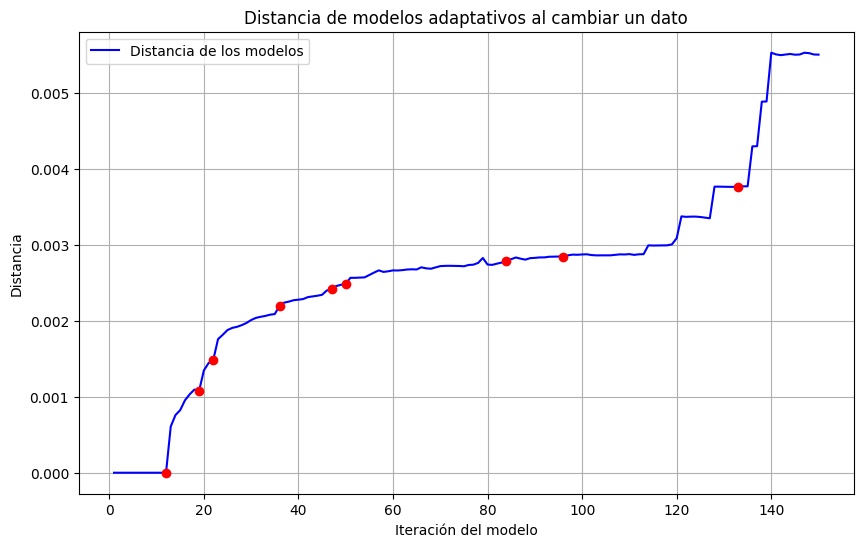

In [77]:
x = np.linspace(1, len(diffAdaptative), len(diffAdaptative))

plt.figure(figsize=(10, 6))

plt.plot(x, diffAdaptative, label = 'Distancia de los modelos', color = 'blue')

indices_cambio = np.where(cambioAdaptative)[0]

marcas_x = x[indices_cambio]
marcas_y = np.array(diffAdaptative)[indices_cambio]
plt.scatter(marcas_x, marcas_y, color='red', zorder=5)

plt.title('Distancia de modelos adaptativos al cambiar un dato')
plt.xlabel('Iteración del modelo')
plt.ylabel('Distancia')
plt.legend()
plt.grid()
plt.show()

Podemos ver que una vez que revisa el dato cambiado, los dos modelos se separan y a partir de ahí se comienzan a alejar a un ritmo casi constante y monótono (sin importar si vuelve a ver dicho dato). Esto se debe a que al moverse en el espacio de búsqueda, ya empiezan a caer a un diferente mínimo local (ya que la función no es convexa en el espacio estudiado) y se siguen moviendo hacia allá. Ahora veamos que ocurre en el algoritmo de Langevin con paso fijo.

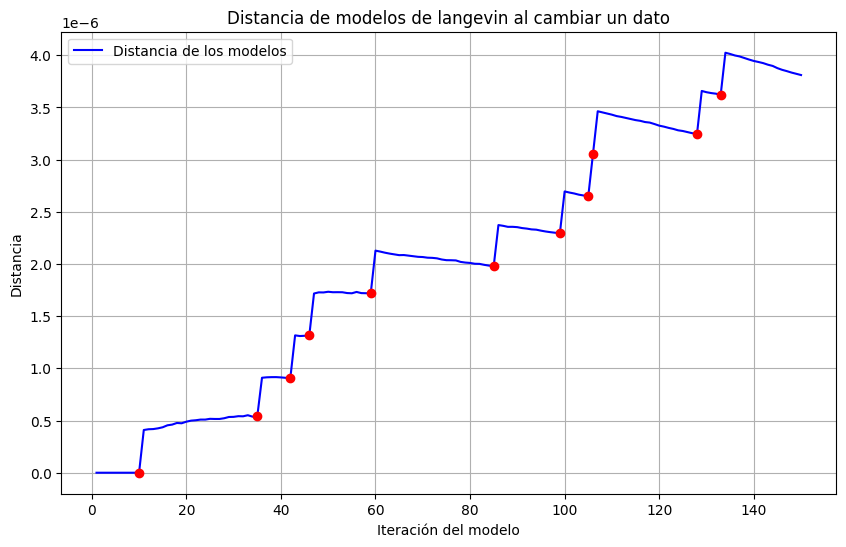

In [78]:
x = np.linspace(1, len(diffLangevin), len(diffLangevin))

plt.figure(figsize=(10, 6))

plt.plot(x, diffLangevin, label = 'Distancia de los modelos', color = 'blue')

indices_cambio = np.where(cambioLangevin)[0]

marcas_x = x[indices_cambio]
marcas_y = np.array(diffLangevin)[indices_cambio]
plt.scatter(marcas_x, marcas_y, color='red', zorder=5)

plt.title('Distancia de modelos de langevin al cambiar un dato')
plt.xlabel('Iteración del modelo')
plt.ylabel('Distancia')
plt.legend()
plt.grid()
plt.show()

Notemos que cuando revisan el dato distinto se empiezan a separar las soluciones. Sin embargo, en este modelo se puede ver como las soluciones se comienzan a juntar (no es monónota la función que mide la distancia), hasta que vuelven a ver el dato distinto (y nuevamente se separan un poco). Así, a diferencia del anterior se puede ver como los modelos se intentan volver a juntar, esto se debe a que este algoritmo tiene una mejor estabilidad ya que con el azar es capaz de escapar de mínimos locales, a diferencia del anterior.